In [1]:
### inversely project HRDEM to geographic CRS
import glob, rasterio, gdal

def reverse_projection(input_dem,output_dem):
    ''' A function to reversely project HRDEM (m) to the geographic space (degree) '''
    hrdem = rasterio.open(input_dem)
    wrap_option = gdal.WarpOptions(format = hrdem.meta.get('driver'), 
                       outputType = gdal.GDT_Float32,
                       srcSRS = hrdem.meta.get('crs'),
                       dstSRS = 'EPSG:4617', # NAD83(CSRS)
                       dstNodata = hrdem.meta.get('nodata'),
                       creationOptions = ['COMPRESS=LZW'])
    gdal.Warp(output_dem, input_dem, options = wrap_option)

# find out all HRDEM datasets in the Data directory
HRDEM_TIFS = glob.glob('Data/HRDEM_*.tif')

for tif in HRDEM_TIFS:  
    out = tif[:-4]+'_4617.tif' # be careful index is hardcoded!
    reverse_projection(tif,out)

print ("Inversely project HRDEM successfully!")

Inversely project HRDEM successfully!


In [3]:
### mosaic HRDEMs
import gc, os, glob, rasterio
from rasterio.merge import merge

dem_fps = glob.glob('Data/HRDEM_*_4617.tif')
src_files_to_mosaic = []

for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

if len(src_files_to_mosaic) == 1:
    src.close()
    os.rename('Data/HRDEM_1_4617.tif', 'Data/HRDEM_mosaic.tif')
else:
    # Merge function returns a single mosaic array and the transformation info
    mosaic_dem, mosaic_trans = merge(src_files_to_mosaic, res=src.res, nodata=-32767.0, method='first')
    
    # Copy the metadata
    mosaic_meta = src.meta.copy()
    
    # Update the metadata
    mosaic_meta.update({"driver": "GTiff","height": mosaic_dem.shape[1],"width": mosaic_dem.shape[2], "compress":'lzw', 
                        "count":1,"dtype": 'float32',"nodata": -32767.0,"transform": mosaic_trans,"crs": "EPSG:4617"})
    
    # Write the mosaic raster to disk
    with rasterio.open("Data/HRDEM_mosaic.tif", "w", **mosaic_meta) as dest:
        dest.write(mosaic_dem)
    
    src.close()
    del mosaic_dem, mosaic_trans, mosaic_meta
    gc.collect()

print ("Mosaic HRDEMs successfully!")

Mosaic HRDEMs successfully!


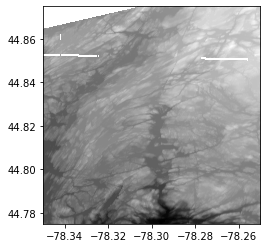

Crop to area of interest successfully!


In [1]:
### crop to area of interest
import json, rasterio
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
%matplotlib inline

# load rasters
hrdem = rasterio.open('Data/HRDEM_mosaic.tif')

# load study area shp
boundingbox_gdf = gpd.GeoDataFrame.from_file('Data/study_area.shp')
boundingbox_gdf = boundingbox_gdf.set_crs("EPSG:4617") # NAD83 CSRS

def getFeatures(gdf):
    ''' A funcion to parse features from GeoDataFrame in such a manner that rasterio wants them '''
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

# call the function to get coords in json
boundingbox_coords = getFeatures(boundingbox_gdf)

# crop the mosaic CDEM to the extent of study area
hrdem_out_img, hrdem_out_transform = mask(dataset=hrdem, shapes=boundingbox_coords, crop=True)
hrdem_out_meta = hrdem.meta.copy()
hrdem_out_meta.update({'height': int(hrdem_out_img.shape[1]),'width': int(hrdem_out_img.shape[2]), 
                      "transform": hrdem_out_transform,"compress":'lzw'})

hrdem.close()

# output clipped rasters
with rasterio.open('Data/HRDEM_cgvd2013.tif', "w", **hrdem_out_meta) as dest:
    dest.write(hrdem_out_img)

# plot the cdem with CGVD2013
src = rasterio.open("Data/HRDEM_cgvd2013.tif")
show(src,cmap='gray')
src.close()

print ("Crop to area of interest successfully!")